In [1]:
from fenics import *
import matplotlib.pyplot as plt

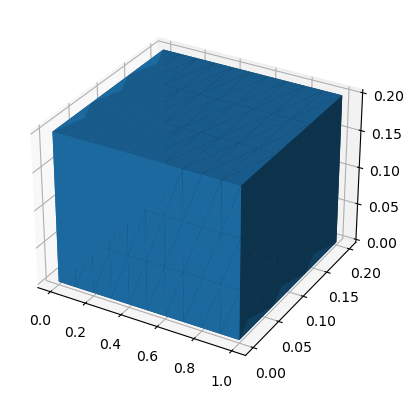

In [2]:
# Variables del problema
L = 1
W = 0.2

mu = 1
lambda_ = 1.25
rho = 1      # unidad: kg/m3
g =  0.016   # aceleracion debida a la gravedad


# Creamos una malla para la geometria de tipo prisma
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 10, 3, 3)
plot(mesh)

In [3]:
V = VectorFunctionSpace(mesh, 'P', 1)

# Definimos la condicion de borde en el extremo izquierdo
tol = 1E-14
def empotramiento(x, on_boundary):
    return on_boundary and x[0]<tol

bc = DirichletBC(V, Constant((0,0,0)), empotramiento)

# Definir la deformacion ε:
def epsilon(u):
    return 0.5 * (nabla_grad(u) + nabla_grad(u).T)

# Definir los esfuerzos σ = λ tr(ε) I₃ + 2 μ ε
def sigma(u):
    return lambda_* tr(epsilon(u))*Identity(d) + 2*mu*epsilon(u)

# Forma variacional de la EDP: a(u,v) = Lv(f):  <σ(u), ε(v)> = <f, v> + <T, v>
u = TrialFunction(V)
d = u.geometric_dimension() # En este caso 3 dimensiones
v = TestFunction(V)
f = Constant((0,0,-rho*g))
T = Constant((0,0,0))

a = inner(sigma(u), epsilon(v))*dx
L = dot(f,v)*dx + dot(T,v)*dx


# Calculamos la solucion
u_sol = Function(V)
solve(a==L, u_sol, bc)


Solving linear variational problem.


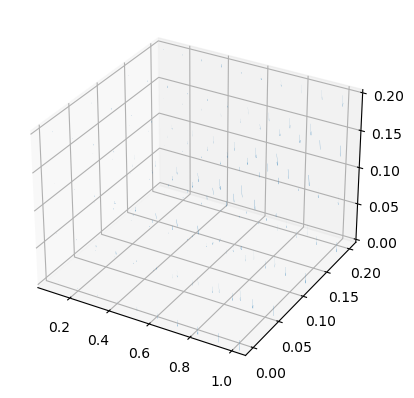

In [4]:
# plot(u_sol, title='Desplazamiento', mode='displacement')
plot(u_sol)

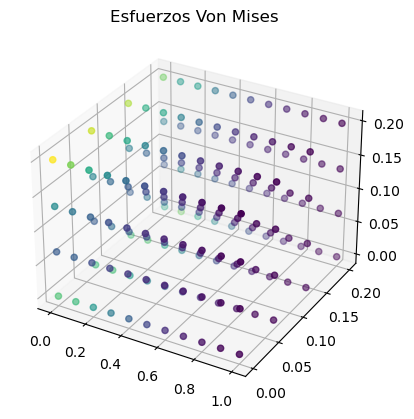

In [7]:
# Plot stress
s = sigma(u_sol) - (1./3)*tr(sigma(u_sol))*Identity(d)
von_Mises = sqrt(3./2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
plot(von_Mises, title='Esfuerzos Von Mises')

min/max u: -3.879704751373988e-06 0.15458538332285882


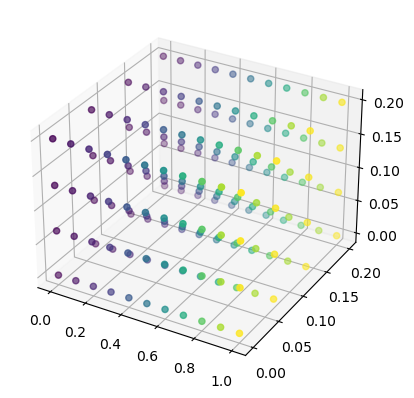

In [8]:
# Compute magnitude of displacement
u_magnitude = sqrt(dot(u_sol, u_sol))
u_magnitude = project(u_magnitude, V)
plot(u_magnitude, 'Magnitud de desplazamiento')
print('min/max u:',
u_magnitude.vector().min(),
u_magnitude.vector().max())

In [11]:
# Escribimos los resultados para visualizarlos en Paraview
u_sol.rename("Desplazamiento", "")
von_Mises.rename("Esfuerzos Von Mises", "")

# Exportamos a paraview
archivo_deflexion = XDMFFile("viga_empotrada/deflexion.xdmf")
archivo_deflexion.parameters["flush_output"] = True
archivo_deflexion.parameters["functions_share_mesh"] = True
archivo_deflexion.write(u_sol, 0.0)
archivo_deflexion.write(von_Mises, 0.0)
